In [ ]:
cd ..

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [ ]:
from alpaca_eval import utils, metrics, annotators, constants, analyze, plotting
import pandas as pd

In [168]:
df=pd.read_json("results/all_annotations.json")

In [169]:
assert len(df["generator_1"].unique()) == 1

In [170]:
def pairwise_ttest(df):
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)

    for i in df. columns:
        for j in df.columns:
            if i == j:
                p_values.loc[i, j] = np.nan
            else:
                t_stat, p_val = stats.ttest_rel(df[i], df[j], nan_policy="omit")
                p_values.loc[i, j] = p_val

    return p_values

In [320]:
def get_ttest_df(df, n_samples=None, random_state=123, sorted_idx=None):
    """return a dataframe of pairwise relative ttest with potential subsampling"""
    df_pivoted = df.pivot(index="instruction", values="preference", columns=["generator_2"])
    if n_samples is not None:
        df_pivoted = df_pivoted.sample(n=n_samples, random_state=random_state)
    win_rate = metrics.pairwise_to_winrate(df["preference"])['win_rate']
    if sorted_idx is None:
        sorted_idx = list(df.groupby("generator_2")["preference"].apply(lambda x: metrics.pairwise_to_winrate(x)['win_rate']).sort_values(ascending=False).index)
    return pairwise_ttest(df_pivoted[sorted_idx].replace({0:1, 1:0})).astype(float)  # draw is 0 but to test order it should be in the middle

In [307]:
import numpy as np
from scipy import stats
import seaborn as sns
df_ttest =  get_ttest_matrix(df)

Are models statistically significantly different from each others 

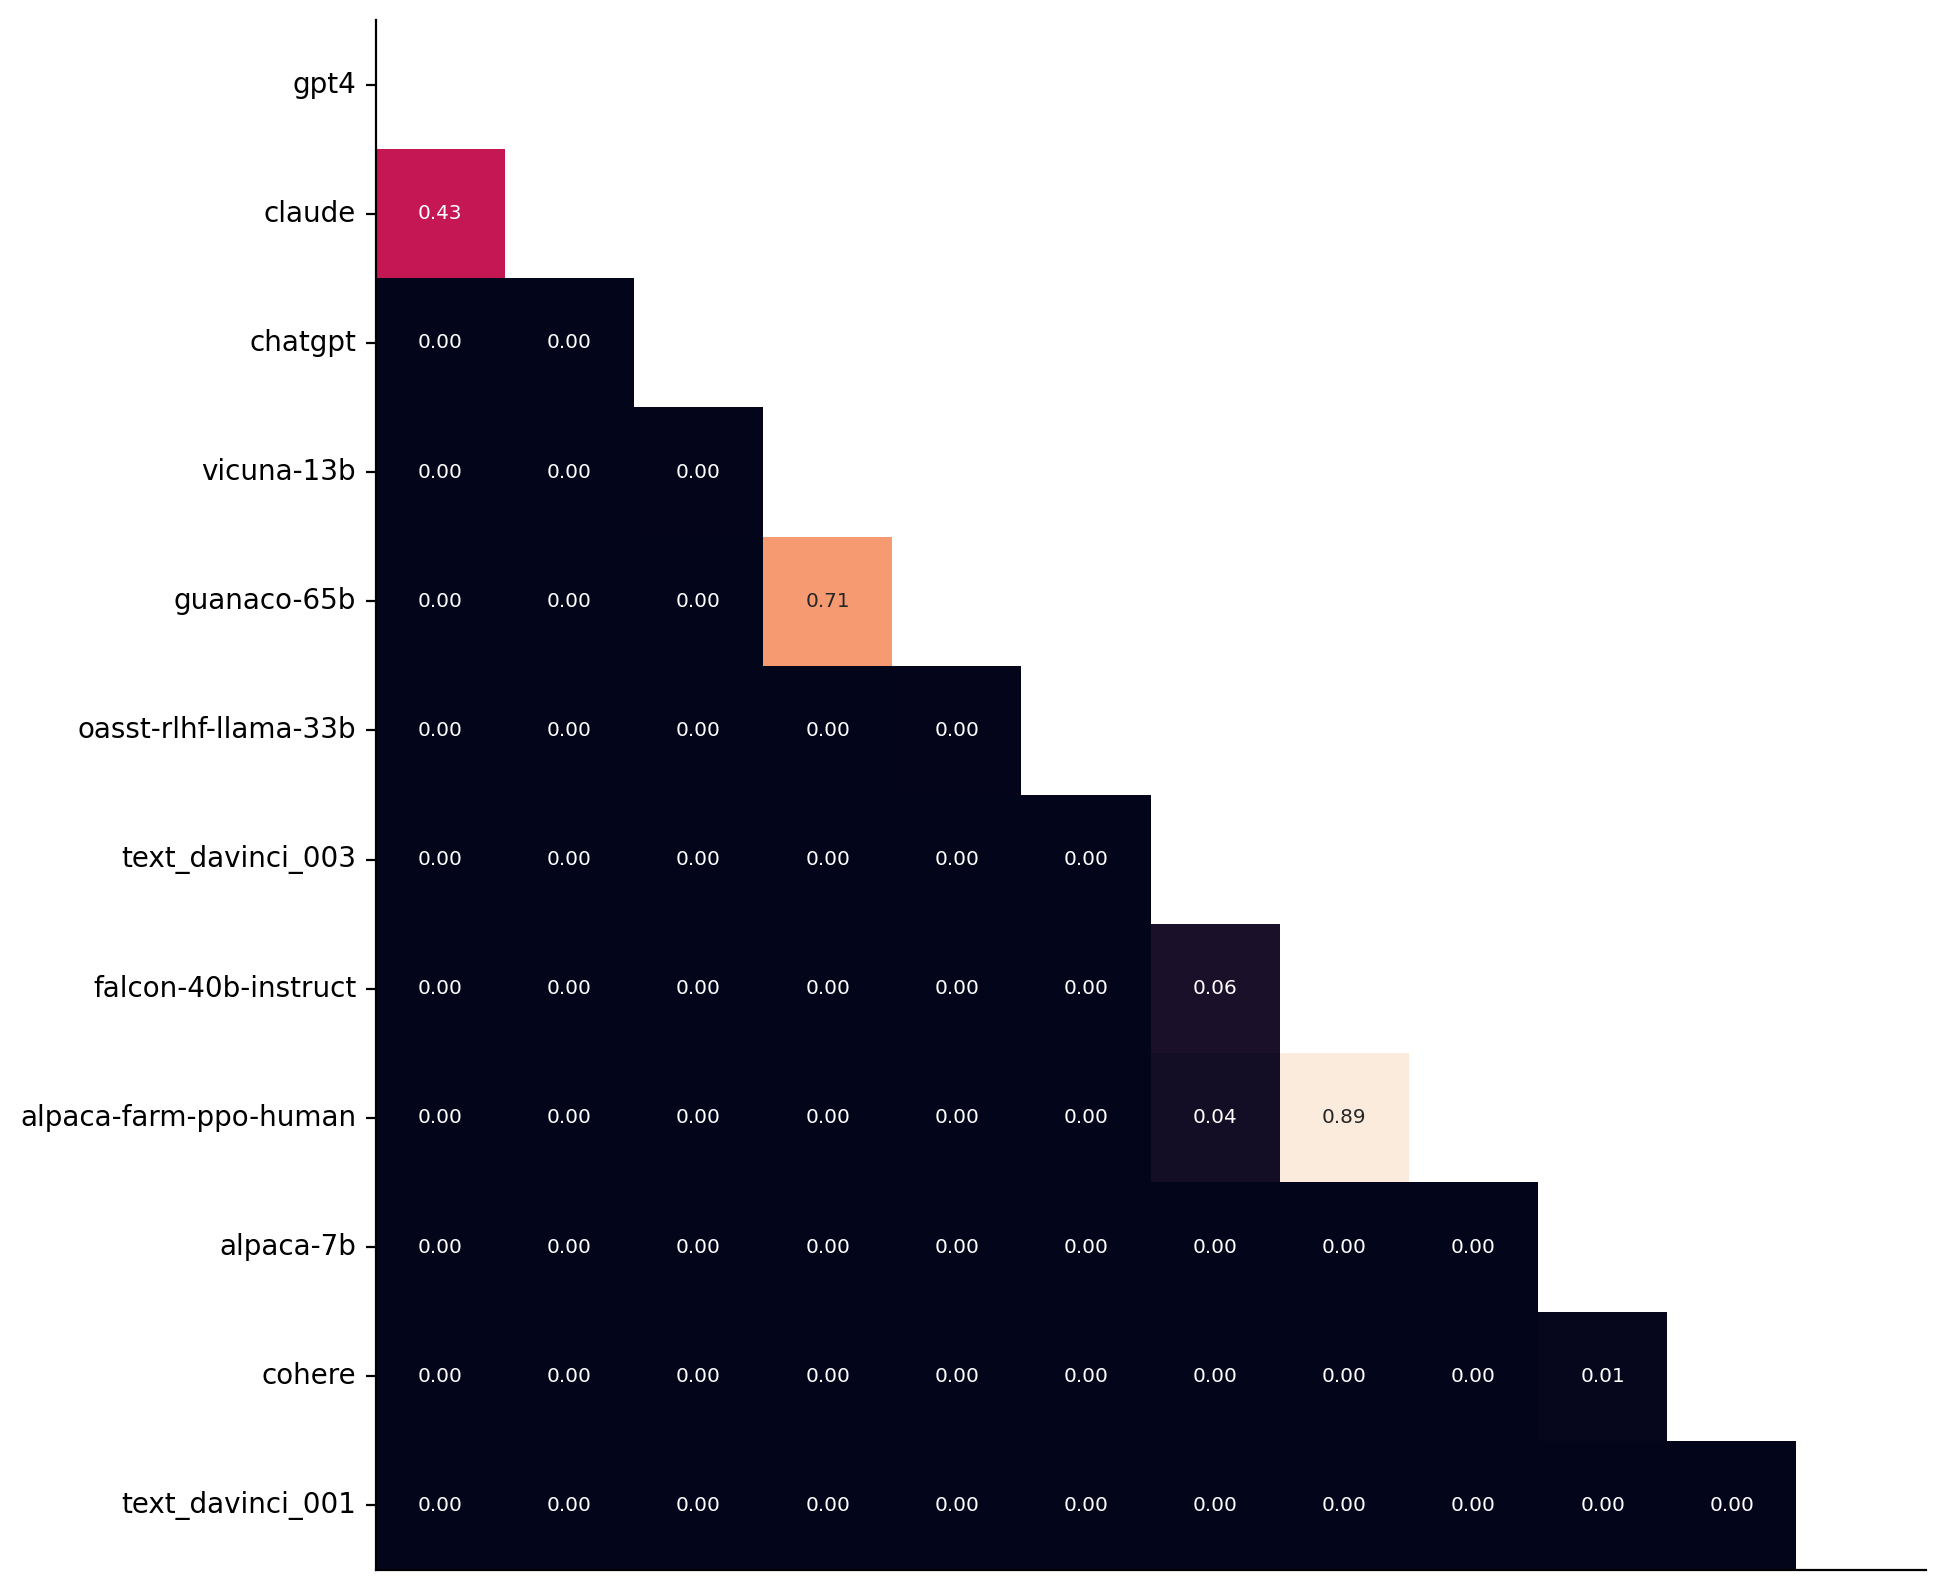

In [347]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 15))
with plotting.plot_config(font_scale=0.4):
    g = sns.heatmap(df_ttest.astype(float), annot=True, fmt=".2f", cbar=False, square=True, xticklabels=False,ax=ax,
            mask=np.triu(np.ones_like(df_ttest, dtype=bool)),
                    cmap=sns.color_palette("rocket", as_cmap=True)
               )
    g.set(xlabel="", ylabel="")

This shows that the AlpacaEval has enough power to distinguish between each other. But it is also fairly large 800 examples, one might this wonder on which of the sub-datasets / distribution do these models differ. As we care about the distribution of the data rather than the size, we need to control for the dataset size. The smallest 

In [309]:
min_dataset_size = df.drop_duplicates("instruction").groupby("dataset")["instruction"].count().min()

In [310]:
all_pvalues = dict()
for d in df["dataset"].unique():
    df_sub = df.query(f"dataset=='{d}'")
    all_pvalues[d] = get_ttest_matrix(df_sub, n_samples=min_dataset_size)
all_pvalues["AlpacaEval"] = get_ttest_matrix(df, n_samples=min_dataset_size)

In [311]:
for i, (key, curr_df) in enumerate(all_pvalues.items()):
    print(key, f"mean p-val: {curr_df.mean(axis=None):.3f}", f"max p-val: {curr_df.max(axis=None):.3f}")



helpful_base mean p-val: 0.085 max p-val: 0.825
koala mean p-val: 0.097 max p-val: 1.000
oasst mean p-val: 0.084 max p-val: 1.000
selfinstruct mean p-val: 0.156 max p-val: 1.000
vicuna mean p-val: 0.074 max p-val: 1.000
AlpacaEval mean p-val: 0.102 max p-val: 1.000


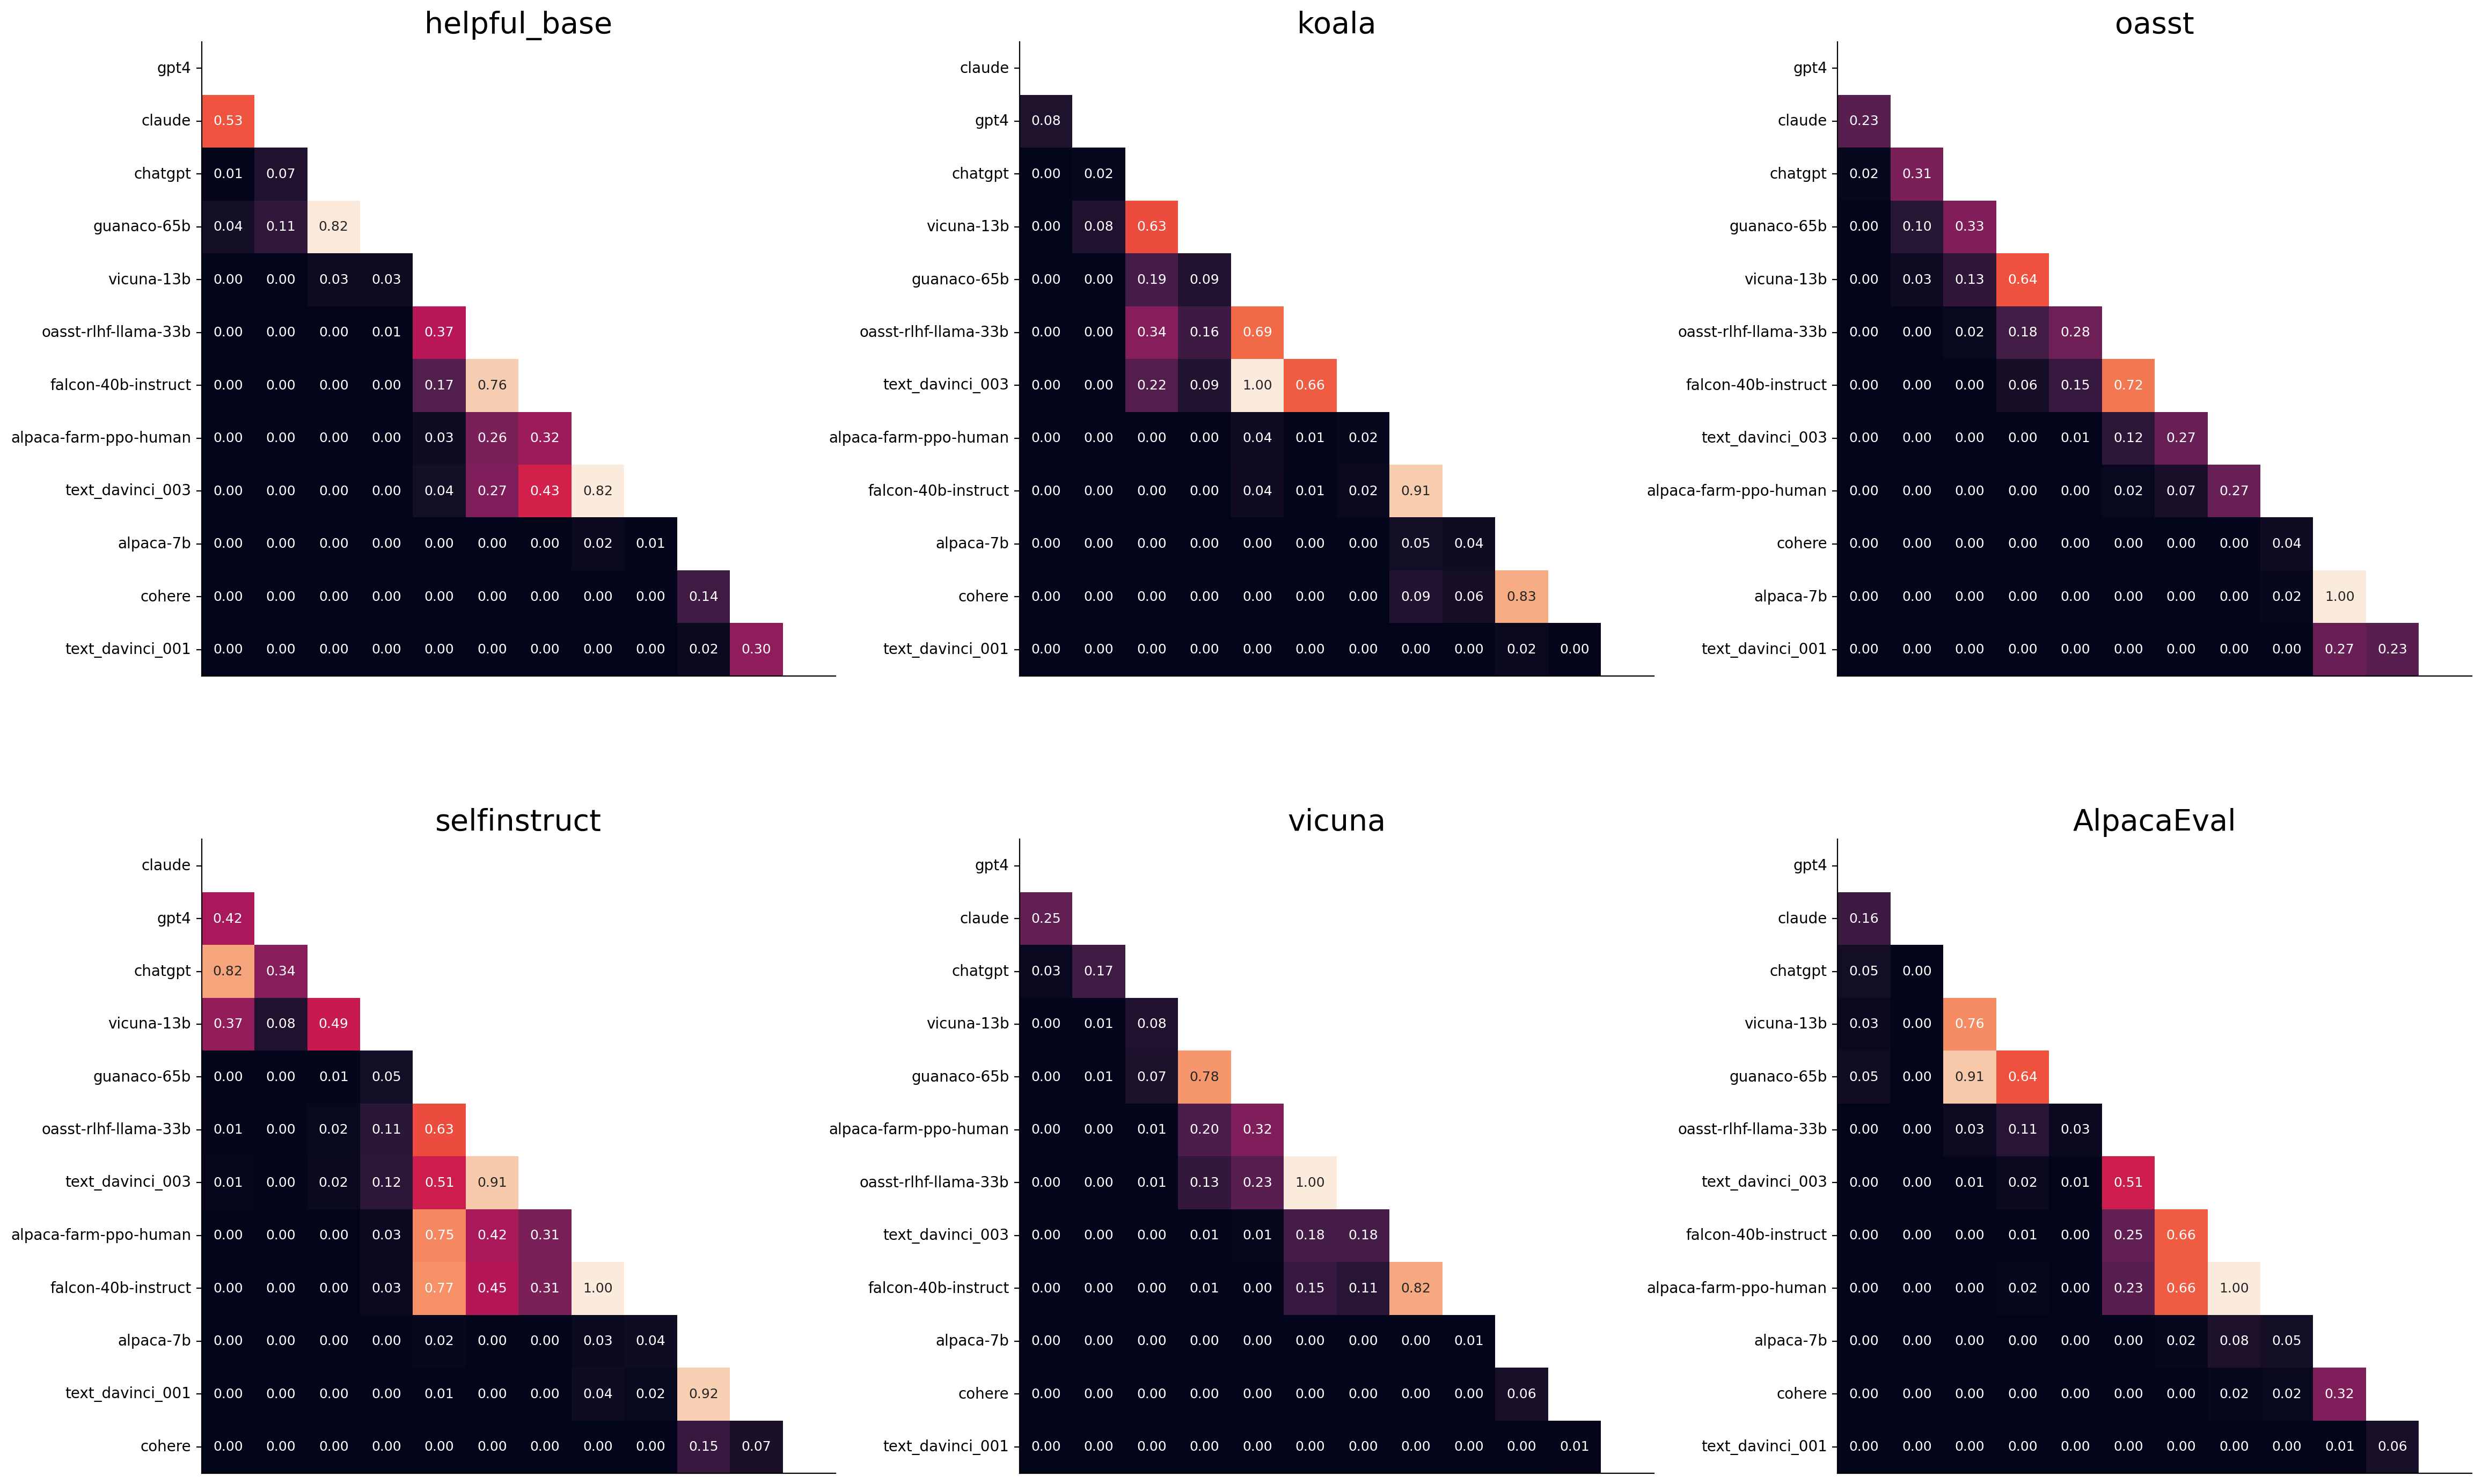

In [312]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(23, 15))

with plotting.plot_config(font_scale=0.5):
    for i, (key, curr_df) in enumerate(all_pvalues.items()):
        ax = axes[i//3][i%3]
        g = sns.heatmap(curr_df, annot=True, fmt=".2f", cbar=False, square=True, xticklabels=False,ax=ax,
                mask=np.triu(np.ones_like(curr_df, dtype=bool)))
        ax.set_title(key, fontsize=20)
        g.set(xlabel="", ylabel="")
        
    for i in range(len(all_pvalues), axes.size):
        ax = axes.flatten()[i]
        ax.set_visible(False)
    
    # adjust spacing between plots
    plt.tight_layout()

In [321]:
all_sub_ttest_df = {n: get_ttest_df(df, n_samples=n, random_state=123, sorted_idx=list(df_ttest.index)) 
                    for n in range(50,len(df["instruction"].unique()),50)}

In [1]:
all_sub_ttest_df

NameError: name 'all_sub_ttest_df' is not defined

In [322]:
df_describe = pd.DataFrame({"mean":{k:v.mean(axis=None) for k,v in all_sub_ttest_df.items()},
                  "90% quantile":{k:v.stack().quantile(q=0.9) for k,v in all_sub_ttest_df.items()},
                  "max":{k:v.max(axis=None) for k,v in all_sub_ttest_df.items()},
})

In [323]:
melted = df_describe.melt(ignore_index=False, value_name="p-value", var_name="aggregator").reset_index(names="# samples")

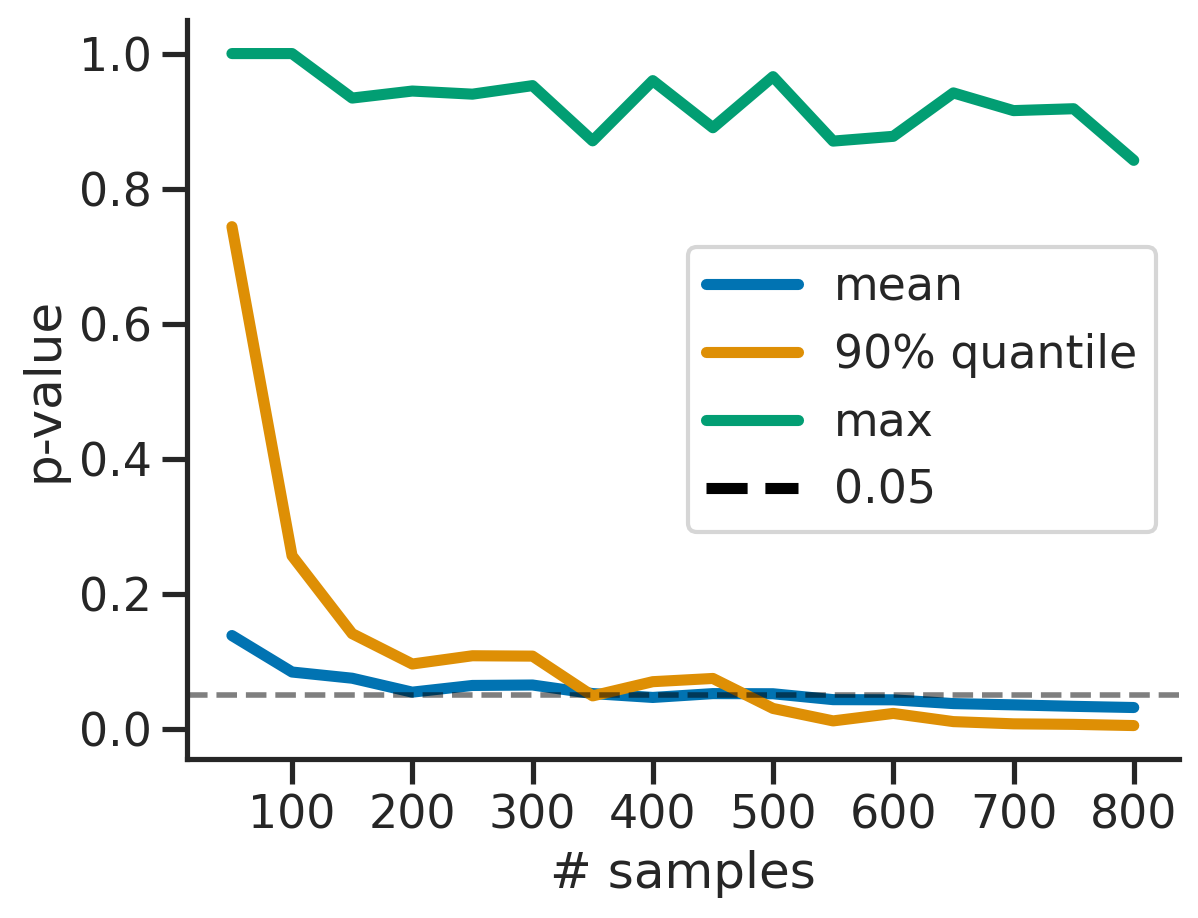

In [324]:
from matplotlib.lines import Line2D

with plotting.plot_config(rc={'lines.linewidth': 4, "axes.grid": False}):
    ax = sns.lineplot(melted, 
                 x="# samples",
                 y = "p-value", 
                hue="aggregator")

    ax.axhline(y=0.05, color='black', linestyle='--', linewidth=2, alpha=0.5)


    # Get the handles and labels from the existing line plot legend
    handles, labels = ax.get_legend_handles_labels()

    # Create a new legend element for the horizontal line
    legend_elements = [Line2D([0], [0], color='black', linestyle='--', label='0.05')]

    # Combine the handles, labels, and new legend element
    all_handles = handles + legend_elements
    all_labels = labels + ['0.05']

    # Plot the combined legend
    ax.legend(handles=all_handles, labels=all_labels)

In [351]:

arr_min_samples = np.minimum.reduce([np.where(v < 0.05, k, float("inf")) for k,v in all_sub_ttest_df.items()])
arr_min_samples[np.isinf(arr_min_samples)] = np.nan
df_min_samples = pd.DataFrame(arr_min_samples, index=df_ttest.index, columns=df_ttest.index)

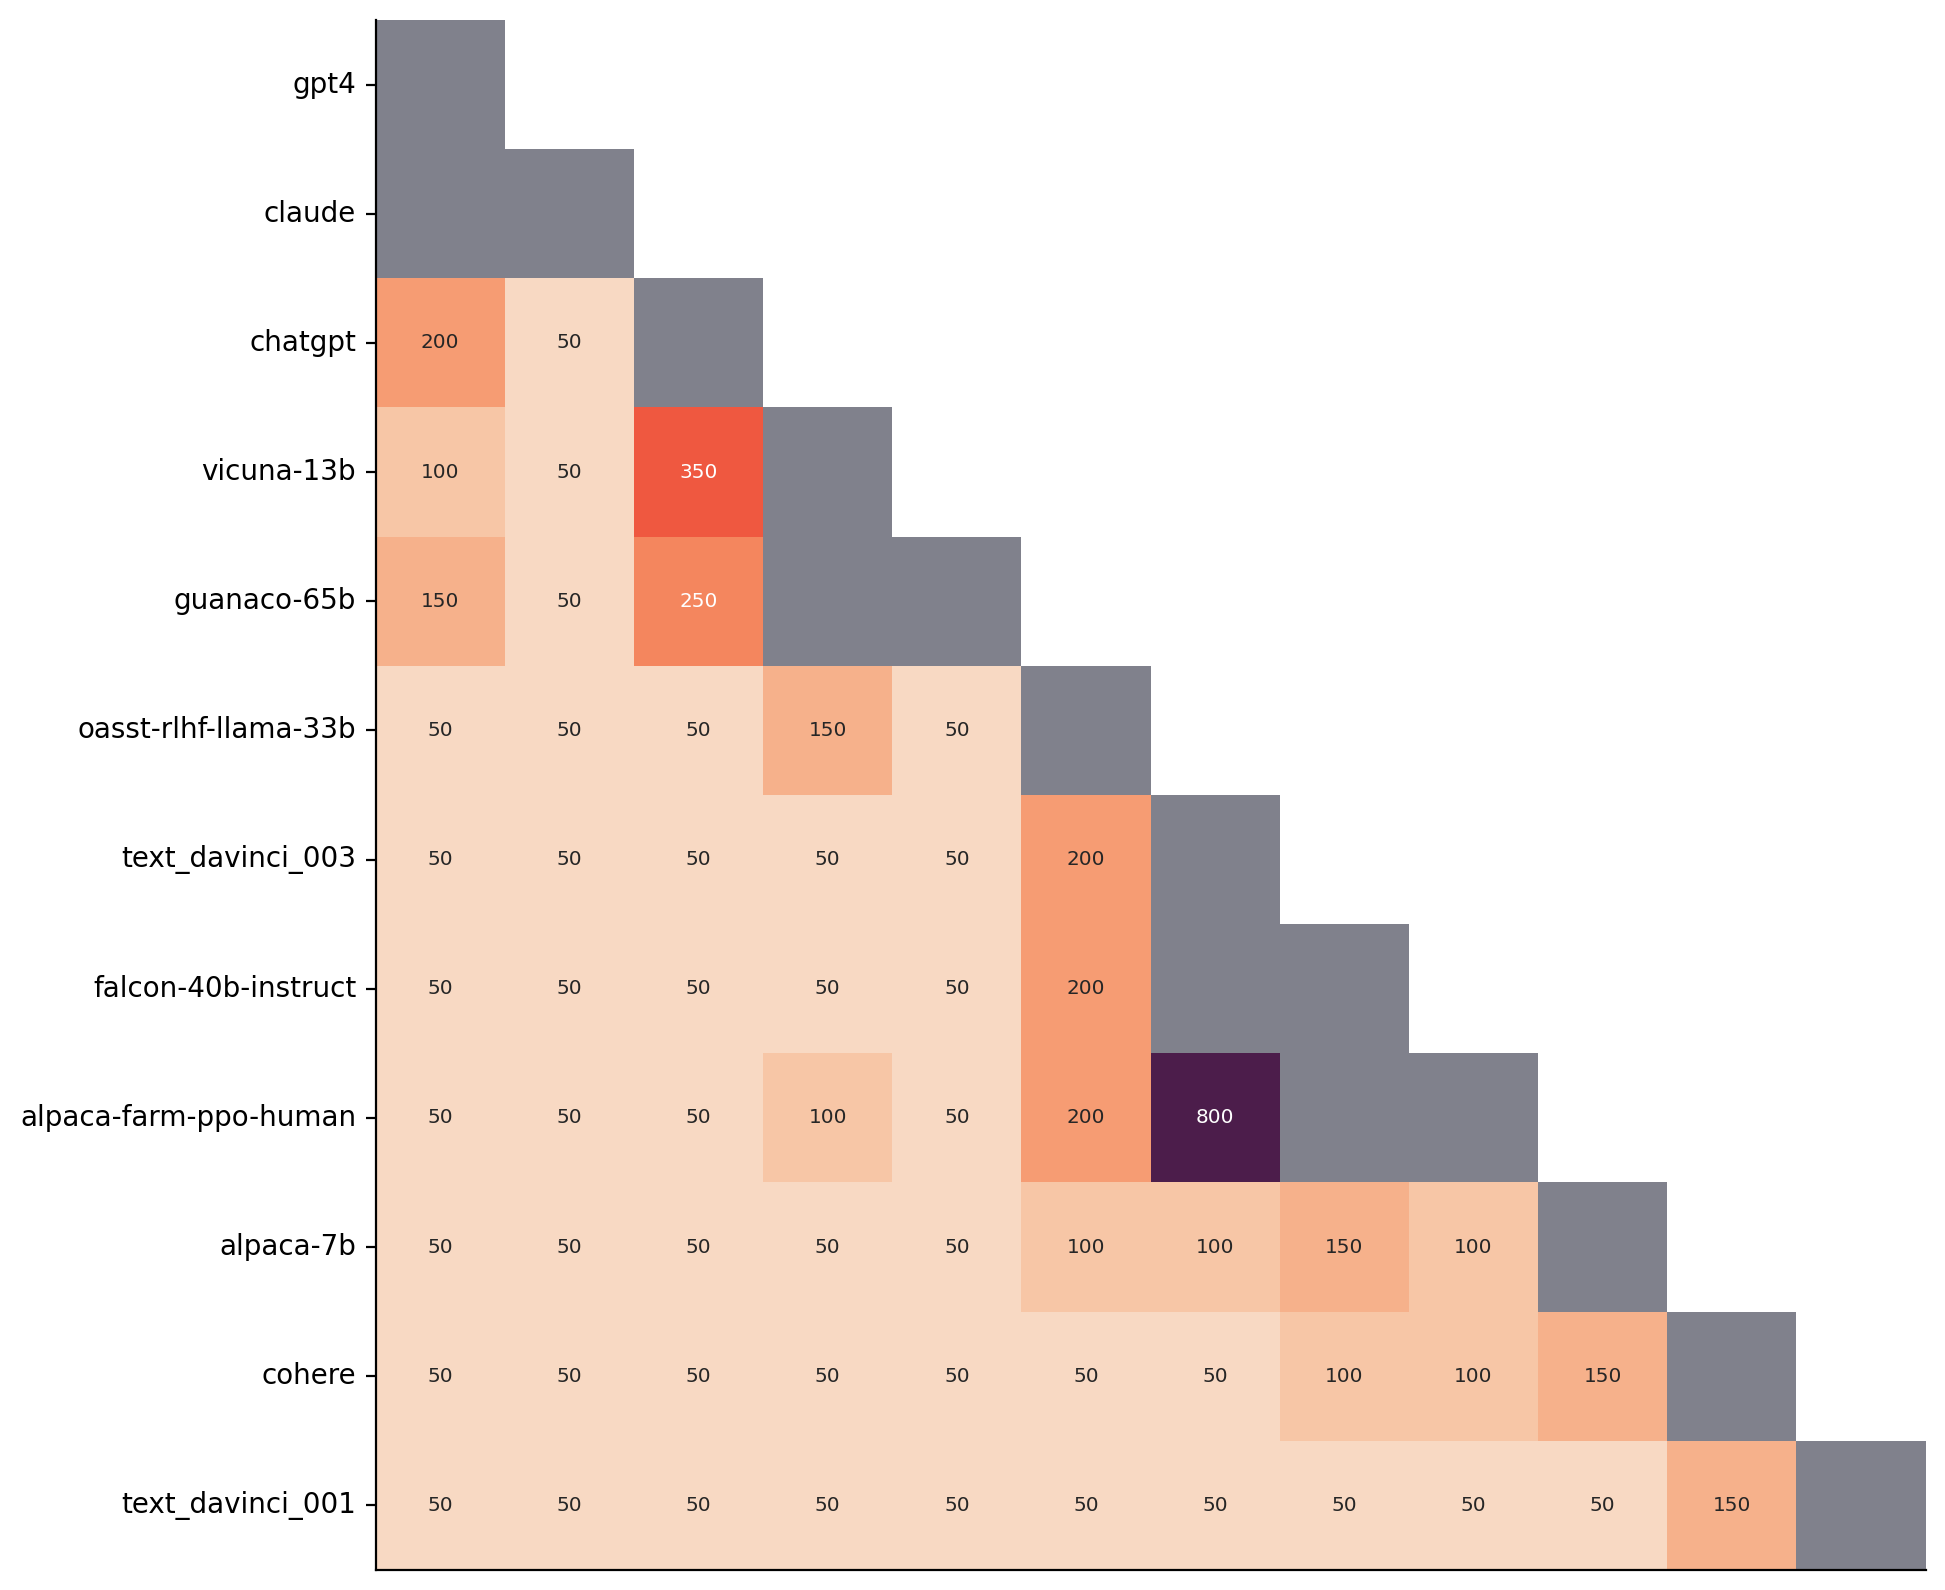

In [394]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 15))
with plotting.plot_config(font_scale=0.4):

    sns.heatmap(df_min_samples.isnull(),cbar=False,color='black',alpha=0.5, 
                mask=~df_min_samples.isnull() | np.triu(np.ones_like(df_ttest, dtype=bool), k=1) )
    g = sns.heatmap(df_min_samples, annot=True, fmt=".0f", cbar=False, square=True, xticklabels=False,ax=ax, vmin=0, vmax=1000, 
                    cmap=sns.color_palette("rocket_r", as_cmap=True),
            mask=np.triu(np.ones_like(df_ttest, dtype=bool)))
    
    g.set(xlabel="", ylabel="")